## 1. Постановка задачи


В данном проекте вы решите настоящую бизнес-задачу в области маркетинга. Вам предстоит произвести сегментацию клиентов на основе их покупательской способности, частоты совершения заказов и срока давности последнего заказа, а также определить оптимальную стратегию взаимодействия с ними.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Маркетинг — неотъемлемая часть любого бизнеса. Для повышения прибыли компании важно понимать своего клиента, его пожелания и предпочтения. С появлением электронной коммерции, или онлайн-продаж, стало намного проще собирать данные о клиентах, анализировать их, находить закономерности и реализовывать маркетинговые кампании.

Большинство интернет-магазинов используют инструменты веб-аналитики, чтобы отслеживать просмотры страниц, количество и поведение посетителей и коэффициент отказов. Но отчёта из Google Analytics или аналогичной системы может быть недостаточно для полного понимания того, как клиенты взаимодействуют с сайтом. Компаниям важно иметь возможность быстро и точно реагировать на перемены в поведении клиентов, создавая инструменты, которые обнаруживают эти изменения практически в режиме реального времени.

Машинное обучение помогает поисковой системе анализировать огромное количество данных о посетителях платформы, узнавать модели поведения профессиональных покупателей, определять категорию клиентов (например, лояльные/перспективные/новички/спящие/ушедшие) и выбирать правильную стратегию взаимодействия с ними.

Стоит также отметить, что компании, использующие машинное обучение на своих платформах электронной коммерции, могут постоянно повышать эффективность бизнес-процессов: настраивать товарную выборку персонально для каждого покупателя и предлагать выгодную цену в соответствии с бюджетом клиента и т. д. Эта задача относится к категории построения рекомендательных систем, речь о которых пойдёт в следующем разделе нашего курса.

Как правило, наборы данных для электронной коммерции являются частной собственностью и, следовательно, их трудно найти среди общедоступных данных. 

**Бизнес-задача:** произвести сегментацию существующих клиентов, проинтерпретировать эти сегменты и определить стратегию взаимодействия с ними.

**Техническая задача для вас как для специалиста в Data Science:** построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.

**Основные цели проекта:**
1. Произвести предобработку набора данных.
2. Провести разведывательный анализ данных и выявить основные закономерности.
3. Сформировать категории товаров и клиентов. 
4. Построить несколько моделей машинного обучения, решающих задачу кластеризации клиентов, определить количество кластеров и проинтерпретировать их.
5. Спроектировать процесс предсказания категории интересов клиента и протестировать вашу модель на новых клиентах.



## 2. Знакомство с данными. 

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import mixture 
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import silhouette_score
import warnings 
warnings.filterwarnings("ignore")
from IPython.display import display, HTML

plt.rcParams["patch.force_edgecolor"] = True



Первым делом необходимо понять, с какими данными нам предстоит работать, и произвести базовую предобработку данных, переведя признаки в необходимые для дальнейшей работы форматы.


Для начала давайте познакомимся с нашими данными:

In [2]:
df = pd.read_csv(
    "./data/customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print(f'Data shape: {df.shape}')
df.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


Итак, у нас есть данные о более чем полумиллионе транзакций. Каждая из них описывается следующими признаками:

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.

Проведём анализ структуры таблицы.


### Задание 2.1
Сколько столбцов в данных кодируются числовыми типами (int/float)?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### Задание 2.2
Выберем столбцы, в которых есть хотя бы один пропуск:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country 

In [4]:
# Узнаём количество пропусков
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### Задание 2.3
Судя по описанию задачи, нам должны были предоставить данные за годовой период — проверим, так ли это.

Преобразуем столбец InvoiceDate в формат datetime.
Укажем, за какой промежуток времени представлены данные:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09


In [5]:
# Преобразовываем столбец InvoiceDate в формат datetime
df['InvoiceDate'] =  pd.to_datetime(df['InvoiceDate'])
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2010-12-01 08:26:00
2011-12-09 12:50:00


### Задание 2.4

1) Каково максимальное количество товаров в заказе (Quantity)? Ответ приведём в виде целого числа.

2) Каково минимальное количество товаров в заказе (Quantity)? Ответ приведём в виде целого числа.

3) Сколько, согласно данным, стоит самый дешёвый товар (за исключением товаров с отрицательной стоимостью)?

In [6]:
# Выводим описательную статистику 
df[df['UnitPrice']>=0].describe()

,Quantity,UnitPrice
count,541907.000000,541907.000000
mean,9.552281,4.651957
std,218.081560,94.395447
min,-80995.000000,0.000000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


#### Вывод:  Из описательной статистики мы видим что: 
Максимальное количество товаров Quantity = 80995 

Минимальное количество товаров Quantity = -80995

самый дешёвый товар (за исключением товаров с отрицательной стоимостью) = 0.00

### Задание 2.5
1) Сколько уникальных клиентов покупали товары за период выгрузки датасета?

2) Сколько уникальных стран содержится в столбце Country (исключая специальный код 'Unspecified', обозначающий неопределенную страну)?

3) Укажем идентификатор самого популярного товара (StockCode):
* 85123A
* 64812
* 51242
* 24151B


In [7]:
# делаем описательную статистику для типа object
df.describe(include=['object'])

,InvoiceNo,StockCode,Description,CustomerID,Country
count,541909,541909,540455,406829,541909
unique,25900,4070,4223,4372,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,17841,United Kingdom
freq,1114,2313,2369,7983,495478


#### Вывод:  

Уникальных клиентов можно определить по уникальным значениям в столбце CustomerID. Исходя из  данных, уникальных клиентов  4372.

Исходя из  данных, уникальных стран  37.

Исходя из данных, самый популярный товар имеет StockCode '85123A'.

## 3. Предобработка и очистка данных

На этом этапе нам предстоит подготовить наш датасет для дальнейшего моделирования, произведя очистку данных.


### Задание 3.1
Начнем с пропусков. 

1) Сколько всего в таблице пропущенных значений?

2) Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

Удалим строки, содержащие пропуски в этих столбцах. Сколько строк осталось в таблице?



In [8]:
# Находим строки в которых есть пропуска
df.isnull().sum().sum()
# Удаляем строки в которых есть пропуска
df.dropna(axis=0, inplace=True)
# Узнаём сколько строк осталось
df.shape[0]

406829

In [9]:
# Узнаём количество пропусков
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### Задание 3.2
Следом за пропусками проверим наличие дубликатов.

1) Сколько в таблице полностью дублирующихся записей?

2) Удалим дубликаты из таблицы. Сколько строк осталось?



In [10]:
# Узнаём количество дубликатов 
df.duplicated().sum()
# Удаляем дубликаты
df.drop_duplicates(inplace=True)
# Узнаём сколько строк осталось 
df.shape[0]

401604

### Вывод: 
В таблице мы видим  полностью дублирующихся записей: 5225

После удаления дубликатов у нас осталось 401604 строк 

Ранее мы заметили, что в столбце с количеством товара есть отрицательные значения. Давайте разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [11]:
negative_quantity = df[(df['Quantity']<0)]
print(f'Count of entries with a negative number: {negative_quantity.shape[0]}')
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Задание 3.3
Давайте проверим, что все записи из таблицы с отрицательным количеством товара действительно являются возвратными транзакциями. Если транзакция не является возвратом, но содержит отрицательное количество товара, это будет поводом считать её выбросом.

Сколько транзакций из таблицы negative_quantity не содержат в номере заказа признак возврата?

In [12]:
# Используем генератор списка для проверки наличия буквы "C" в каждом номере счета
counter = sum('C' not in i for i in negative_quantity['InvoiceNo'])
# Выводим количество транзакций без признака возврата
print(f"Количество транзакций без признака возврата: {counter}")

Количество транзакций без признака возврата: 0


Давайте подробнее разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:


In [13]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


#### Вывод: 
Уникальные товары в корзине для каждой уникальной пары "клиент-заказ" имеют следующие значения:

Для клиента 12346 и заказа 541431: 1 уникальный товар

Для клиента 12346 и заказа C541433: 1 уникальный товар

Для клиента 12347 и заказа 537626: 31 уникальный товар

Для клиента 12347 и заказа 542237: 29 уникальных товаров

Для клиента 12347 и заказа 549222: 24 уникальных товара

### Задание 3.4
Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

Сколько процентов заказов в таблице являются возвратами? Ответ приведём в виде целого числа.


In [14]:
# Добавляем признак отмены заказа в таблицу nb_products_per_basket
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if 'C' in x else 0)

# Рассчитываем процент возвратов
canceled_per = nb_products_per_basket['order_canceled'].mean()*100
print('Процент возвратов заказов:', round(canceled_per))

Процент возвратов заказов: 16


Давайте поближе взглянем на отмененные заказы:


In [15]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [16]:
df[df['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратим внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравним их для двух транзакций. 

#### Вывод: 
В данном случае, приведенные данные представляют собой пример "заказ-отмена", где клиент с ID 12346 совершил исходный заказ (InvoiceNo 541431) на приобретение 74,215 единиц товара с StockCode 23166 (MEDIUM CERAMIC TOP STORAGE JAR) по цене 1.04 за единицу. Позднее этот заказ был аннулирован клиентом с использованием отрицательного количества в заказе отмены (InvoiceNo C541433) того же товара с теми же ценой и идентификатором заказа, что и исходный.

Такие транзакции "заказ-отмена" часто возникают в бизнес-процессах, когда клиенты отменяют или возвращают заказанные товары. Они позволяют вести учет отмененных сделок и корректировать соответствующие показатели, такие как общее количество проданных товаров.

### Задание 3.5
Выдвигаем гипотезу: для каждой отменённой транзакции в базе данных (таблица df) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

* Верна ли гипотеза?
* Да, верна



In [17]:
for i, row in negative_quantity.iterrows():
    # Получаем необходимые параметры из текущей записи
    customer_id = row['CustomerID']
    stock_code = row['StockCode']
    quantity = row['Quantity']

    # Проверяем наличие аналогичной записи в исходных данных с противоположным количеством
    counterpart_transaction = df[
        (df['CustomerID'] == customer_id) &
        (df['StockCode'] == stock_code) &
        (df['Quantity'] == -quantity)
    ]

    # Если аналогичная запись не найдена, гипотеза неверна
    if counterpart_transaction.empty:
        print("Гипотеза неверна: Для отменённой транзакции нет аналога с противоположным количеством.")
        break
else:
    print("Гипотеза верна: Для каждой отменённой транзакции существует аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.")


Гипотеза неверна: Для отменённой транзакции нет аналога с противоположным количеством.


Давайте приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [18]:
df[df['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров мы не найдём. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

### Задание 3.6
Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица df) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

Верна ли гипотеза?
* Да, верна
* Нет, не верна 


In [19]:
# Удаляем скидки из столбца
df_no_discount = negative_quantity[negative_quantity['StockCode'] != 'D']
# Проверка гипотезы на очищенных данных
for i, row in df_no_discount.iterrows():
    customer_id = row['CustomerID']
    stock_code = row['StockCode']
    quantity = row['Quantity']

    # Проверяем наличие аналогичной записи в исходных данных с противоположным количеством
    counterpart_transaction = df_no_discount[
        (df_no_discount['CustomerID'] == customer_id) &
        (df_no_discount['StockCode'] == stock_code) &
        (df_no_discount['Quantity'] == -quantity)
    ]

    # Если аналогичная запись не найдена, гипотеза неверна
    if counterpart_transaction.empty:
        print("Гипотеза неверна: Для отменённой транзакции без скидок нет аналога с противоположным количеством.")
        print(f"Контрпример: транзакция {i} для клиента {customer_id}")
        break
        
# Если цикл завершен без прерывания, то гипотеза верна
else:
    print("Гипотеза верна: Для каждой отменённой транзакции без скидок существует аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.")

Гипотеза неверна: Для отменённой транзакции без скидок нет аналога с противоположным количеством.
Контрпример: транзакция 154 для клиента 15311


Посмотрим, где кроется наша проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [20]:
df[(df['CustomerID'] == '15311') & (df['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Мы подготовили функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создаём в таблице с транзакциями новый столбец QuantityCanceled.


In [21]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента
        # Добавляем количество отмененного в столбец QuantityCanceled 
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

df['QuantityCanceled'] = get_quantity_canceled(df)


### Задание 3.7
Подсчитаем суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [22]:
# суммарное количество отменённых товаров в столбце QuantityCanceled
display(df['QuantityCanceled'].sum())

245266.0

## Задание 3.8
Теперь, когда мы разобрались с транзакциями-возвратами, они больше нам не понадобятся. 
Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.  
Сколько записей осталось?

In [23]:
# Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара
transaction_df = df[df['Quantity'] >= 0]
# выведем количество записей
print("Количество записей:", transaction_df['InvoiceNo'].shape[0])
# Применем к нашему DataFrame
df = transaction_df

Количество записей: 392732


Следующая проблема — это специальные виды транзакций. Например, ранее мы уже видели, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


### Задание 3.9
С помощью регулярных выражений найдём такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 

Подсказка: Поиск подстрок в столбце можно организовать с помощью str.contains(). В качестве шаблона для поиска используйте строку '^[a-zA-Z]+'. Параметр regex установите в значение True.

1) Сколько уникальных специальных видов транзакций нам удалось найти?

Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы. 

2) Сколько записей осталось?



In [24]:
# Находим уникальные специальные виды транзакций
special_transactions = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()

# Удаляем специальные транзакции из таблицы
df = df[~df['StockCode'].isin(special_transactions)]

# Выводим количество оставшихся записей
remaining_records = df.shape[0]
print(f'Уникальных видов транзакций: {special_transactions.shape[0]}')
print(f'Осталось записей после удаления специальных транзакций: {remaining_records}')

Уникальных видов транзакций: 6
Осталось записей после удаления специальных транзакций: 391183


### Задание 3.10
Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 

1) В скольких транзакциях цена за единицу товара равна 0?

2) Таких транзакций оказалось менее 1 %, поэтому от них можно просто избавиться. Удалим такие транзакции из таблицы. Сколько записей осталось?



In [25]:
df_copy  = df.copy()

In [26]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [27]:
# Узнаём в скольких транзакциях цена за единицу товара равна 0
unit_price_zero = df[df['UnitPrice'] == 0]
# Удаляем транзакции в которых цена за единицу товара равна 0
df.drop(unit_price_zero.index, inplace=True)
print(f'Транзакции где цена за единицу товара равно 0: {unit_price_zero.shape[0]}')
print("Записей осталось:", df.shape[0])

Транзакции где цена за единицу товара равно 0: 33
Записей осталось: 391150


Поздравляем, этап очистки данных завершён. Сохраним полученный результат в отдельный файл, чтобы впоследствии нам не приходилось повторять эти действия.

## 4. Разведывательный анализ данных

Теперь давайте займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.


### Задание 4.1
Для начала выясним, в каких странах живут клиенты.

Построим график, отражающий количество клиентов в каждой из стран. Обратим внимание, что нам нужны именно уникальные клиенты.

В какой стране живёт наибольшее количество клиентов?

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [28]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0


In [29]:
# Узнаём количество клиентов в каждой из стран
country_df = df['Country'].value_counts().reset_index()
country_df.columns = ['Страны', 'Количество клиентов']
# код для построения географической карты (choropleth map)
fig = px.choropleth(
    country_df,
    locations='Страны',
    locationmode='country names',
    color='Количество клиентов',
    color_continuous_scale='Viridis',
    title='Распределение количества клиентов по странам',
    labels={'Количество клиентов': 'Количество клиентов'}
)

fig.show()

### Вывод: 
Мы видим что в Великобритании живёт наибольшее количество клиентов

### Задание 4.2
Мы посмотрели на распределение клиентов в разрезе стран. А что насчёт заказов?

Постройте визуализацию и выделите топ-3 стран по количеству поступающих заказов.

* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [30]:

# Группировка данных по странам с подсчетом количества заказов в каждой стране
country_orders = df.groupby(by=['Country'],as_index=False)['InvoiceNo'].count().sort_values(by= ['InvoiceNo'], ascending=False)
# Построим горизонтальную столбчатую диаграмму
fig = px.bar(
    country_orders,
    x='Country',
    y='InvoiceNo',
    color='Country',
    title='Топ-3 страны по количеству заказов',
    labels={'InvoiceNo': 'Количество заказов', 'Country': 'Страны'}
)

fig.show()

#### Вывод: 
На графике можно увидеть что топ 3 стран по количеству поступающих заказов: Великобритания, Германия, Франция

### Задание 4.3
Давайте добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**

Чему равна средняя общая стоимость заказов? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [31]:
# добавим в датасет общую цену заказа, назовём её TotalPrice
df['TotalPrice'] = df['UnitPrice'] * (df['Quantity'] - df['QuantityCanceled'])

# Рассчитываем среднюю общую стоимость заказов
print("Средняя общая стоимость заказов:",round(df['TotalPrice'].mean()))



Средняя общая стоимость заказов: 21


### Задание 4.4

Постройте визуализацию и выделите топ-3 стран, клиенты из которых приносят компании больше всего выручки:
* Великобритания (United Kingdom)
* Германия (Germany)
* Франция (France)
* Нидерланды (Netherlands)
* Ирландия (EIRE)
* Австралия (Australia)


In [32]:
# Группируем данные по странам и используем agg для нахождения  клиентов стран которые приносят максимальную выручку
valuable_countries = df.groupby('Country', as_index=False).agg({'TotalPrice': 'sum'}).sort_values(by='TotalPrice', ascending=False)

# Построим горизонтальную столбчатую диаграмму
fig = px.bar(
    valuable_countries,
    x='Country',
    y='TotalPrice',
    color='Country',
    title='Топ-3 страны по максимальной цене за единицу товара',
    labels={'TotalPrice': 'Максимальная цена', 'Country': 'Страны'}
)

fig.show()

#### Вывод 
Топ 3 страны где клиенты приносят больше всего выручки:  Великобритания,  Нидерланды,  Ирландия

Теперь займёмся временными характеристиками.


### Задание 4.5
Добавьте в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Постройте визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. Укажите номер самого прибыльного для компании месяца. Предположите, почему так происходит.

In [33]:
df_copy_first =df.copy() 

In [34]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34


In [35]:
# Создаём признак месяца
df['Month'] = df['InvoiceDate'].dt.month
# Создаём признак дня недели
df['Week'] = df['InvoiceDate'].dt.day_name()
# Создаём признак часа
df['Hour'] = df['InvoiceDate'].dt.hour

month_profit = df.groupby('Month', as_index=False)['TotalPrice'].agg({'TotalPrice': 'sum'}).sort_values(by=['TotalPrice'], ascending=False)


# Визуализация распределения суммарной выручки по месяцам
fig = px.bar(
    month_profit,
    x='Month',
    y='TotalPrice',
    color='Month',
    title='Топ самые прибыльные месяцы по суммарной выручке',
    labels={'TotalPrice': 'Максимальная цена', 'Month': 'Месяц'}
)

fig.show()

#### Вывод: 
Самый прибыльный месяц - Ноябрь. 

Это происходит из-за сезонных факторов: Ноябрь может быть периодом, когда происходит активное покупательное поведение из-за праздников, таких как Черная Пятница и Киберпонедельник, а также подготовки к рождественским и новогодним праздникам. Потребители часто делают покупки в этот период, что может привести к увеличению общей выручки.

### Задание 4.6
Постройте визуализацию количества заказов для каждого дня недели. Укажите день недели, в который, согласно данным, не совершено ни одного заказа:
* Понедельник
* Вторник
* Среда
* Четверг
* Пятница
* Суббота 
* Воскресенье


In [36]:
# Группируем по дням недели и количеству заказов 
Day_of_week = df.groupby(
    'Week', 
    as_index=False
    )['InvoiceNo'].count().sort_values(by=['InvoiceNo'], ascending=False
)
# Строим график по дням недели и количеству заказов 
fig = px.bar(
    Day_of_week,
    x='Week',
    y='InvoiceNo',
    color='Week',
    title= 'Количество заказов для каждого дня недели',
    labels = {'InvoiceNo': 'Количество заказов', 'Week': 'День недели'}
    
)
fig.show()



#### Вывод: 
Cогласно данным мы не видим субботы, нет ни одной транзакции, совершённой в этот день,  скорее всего это связано с выходным днём или ошибкой в данных. 

### Задание 4.7
Выделите дату из признака времени совершения транзакции.
Сгруппируем данные по датам и часам совершения транзакции и найдём количество заказов на каждый день-час. Затем найдём среднее количество ежедневно поступающих заказов в каждый из часов.

Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).

Выберем верные утверждения:
* Больше всего заказов совершается в дневное время в интервале от 18 до 20 часов
* Больше всего заказов совершается в вечернее время в интервале от 10 до 15 часов
* Начиная с 21 часа вечера и до 6 утра (не включительно) заказы не поступают 
* Заказы поступают во все периоды дня


In [37]:
df_copy_three = df.copy()

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391150 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391150 non-null  object        
 1   StockCode         391150 non-null  object        
 2   Description       391150 non-null  object        
 3   Quantity          391150 non-null  int64         
 4   InvoiceDate       391150 non-null  datetime64[ns]
 5   UnitPrice         391150 non-null  float64       
 6   CustomerID        391150 non-null  object        
 7   Country           391150 non-null  object        
 8   QuantityCanceled  391150 non-null  float64       
 9   TotalPrice        391150 non-null  float64       
 10  Month             391150 non-null  int64         
 11  Week              391150 non-null  object        
 12  Hour              391150 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memor

In [39]:
# Выбираем дату из признака совершения транзакци
time_data = df.groupby(['Hour', 'InvoiceDate'], as_index=False)['InvoiceNo'].agg({'InvoiceNo':  'count'})
# Рассчитываем среднее
average_data = time_data.groupby('Hour', as_index=False)['InvoiceNo'].mean()

# Построим график с использованием Plotly
fig = px.line(
    average_data, 
    x='Hour', 
    y='InvoiceNo', 
    markers=True,
    labels={'InvoiceNo': 'Среднее количество заказов', 'Hour': 'Час суток'},
    title='Среднее количество заказов по времени суток'
)
fig.show()






#### Вывод:
Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов.

С 21 часа до 6 утра (не включительно) заказы не поступают.

## 5. RFM-сегментация клиентов: часть 1

Мы добрались до самой интересной части нашей задачи. Нам предстоит сформировать признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого давайте познакомимся с очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, что мы разделяем всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.

In [40]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,Month,Week,Hour
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0,15.30,12,Wednesday,8
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,Wednesday,8
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0,22.00,12,Wednesday,8
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,Wednesday,8
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0,20.34,12,Wednesday,8


### Задание 5.1

Итак, приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта, переведённая в дни:
    $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ — дата и время совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчёта $t_0$ берём дату на один день «старше», чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime — '2011-12-10 00:00:00').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).

Когда мы рассчитываем все характеристики, не забываем дать столбцам результирующей таблицы соответствующие названия.

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391150 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391150 non-null  object        
 1   StockCode         391150 non-null  object        
 2   Description       391150 non-null  object        
 3   Quantity          391150 non-null  int64         
 4   InvoiceDate       391150 non-null  datetime64[ns]
 5   UnitPrice         391150 non-null  float64       
 6   CustomerID        391150 non-null  object        
 7   Country           391150 non-null  object        
 8   QuantityCanceled  391150 non-null  float64       
 9   TotalPrice        391150 non-null  float64       
 10  Month             391150 non-null  int64         
 11  Week              391150 non-null  object        
 12  Hour              391150 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memor

In [42]:
# Добавим текущее время(точку отсчёта)
current_date = pd.to_datetime('2011-12-10 00:00:00')
# вычисляем давность 
Recency = (current_date - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days
# рассчитаем частотность заказов
Frequency = df.groupby('CustomerID')['InvoiceNo'].nunique()
# Рассчитываем общую сумму денег для клиента
Monetary_value = df.groupby('CustomerID')['TotalPrice'].sum()

# Создание RFM-таблицы
rfm_table = pd.DataFrame({'Recency': Recency, 'Frequency': Frequency, 'Monetary_value': Monetary_value})
rfm_table

,Recency,Frequency,Monetary_value
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18280,277,1,180.60
18281,180,1,80.82
18282,7,2,176.60


1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? Ответ округлите до целого числа.

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? Ответ приведите в фунтах стерлингов и округлите до целого числа.



In [43]:
# Выссчитываем количество клиентов совершивших покупку более 200 дней назад 
print(rfm_table[rfm_table['Recency']>200].value_counts().sum())

# Рассчитываем сколько заказов в среднем делает клиент
print(round(rfm_table['Frequency'].mean()))

# Рассчитываем общую сумму денег которую потратил клиент 12360
print(round(rfm_table.loc['12360']['Monetary_value']))


743
4
2302


#### Вывод:
Сколько клиентов совершили покупку более 200 дней назад - 743

Сколько заказов в среднем делает клиент (за представленный годовой период) - 4

Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360 - 2302


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [44]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.


### Задание 5.2
Удалим из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 

Данные о скольких клиентах у нас остались в RFM-таблице?


In [45]:
# Заданные квантили уровня 0.95 для 'Frequency' и 'Monetary'
frequency_95 = rfm_table['Frequency'].quantile(0.95)
monetary_95 = rfm_table['Monetary_value'].quantile(0.95)

# Удаление записей, удовлетворяющих условиям
rfm_table_cleaned = rfm_table[(rfm_table['Frequency'] <= frequency_95) & (rfm_table['Monetary_value'] <= monetary_95)]

# Вывод числа оставшихся клиентов в RFM-таблице
print(f'Число оставшихся клиентов в RFM-таблице: {rfm_table_cleaned.shape[0]}')

Число оставшихся клиентов в RFM-таблице: 4044


После удаления выбросов у нас должны получиться следующие коробчатые диаграммы:


In [46]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы наконец добрались до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. Благо, у нас всего три параметра, по которым мы хотим кластеризовать клиентов, поэтому данные можно визуализировать в виде трёхмерной диаграммы рассеяния. 

Построим визуализацию нашего трёхмерного пространства признаков:


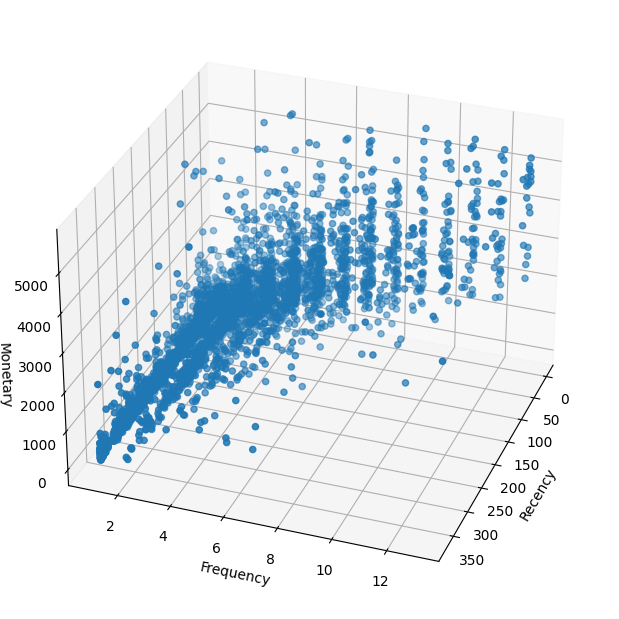

In [47]:
# создадим трёхмерный объект
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# добавим дополнительную ось в объект картинки
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary_value'].to_list()
)
# добавим оси
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Давайте призовём на помощь методы снижения размерности.


### Задание 5.3
Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Давайте для удобства обернём эти шаги по предобработке данных в pipeline.

Создайте pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучим ваш pipeline на RFM-таблице, очищенной от выбросов, и применим к ней трансформацию.

Какую долю дисперсии исходных данных объясняет первая главная компонента? Ответ округлим до двух знаков после точки-разделителя.



Визуализировав пространство главных компонент после декомпозиции мы получим следующую картину:

Попробуем разделить это пространство главных компонент на сегменты. 

Первая главная компонента объясняет следующую долю дисперсии: 0.68


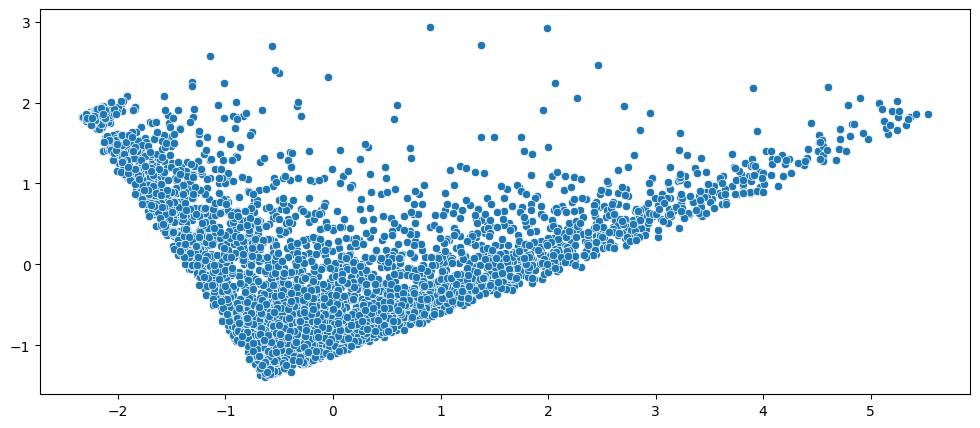

In [48]:
# Создаём pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('PCA', PCA(n_components = 2))
    
])
# обучаем и преобразовываем наш pipeline на RFM-таблице
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)
# Получаем объект PCA из pipeline
pca_component_first = pipeline['PCA'].explained_variance_ratio_[0]
# Выводим долю дисперсии первой главной компоненты 
print('Первая главная компонента объясняет следующую долю дисперсии:', round(pca_component_first, 2))

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x=rfm_table_processed[:,0], y=rfm_table_processed[:,1]);


### Задание 5.4
Попробуем воспользоваться методом k-means. 

Подберём оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставим по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлим до двух знаков после точки-разделителя.


Максимальное значение коэффициента силуэта:  0.52


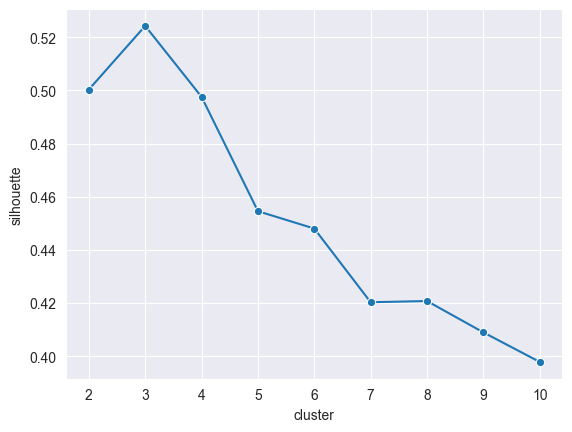

In [49]:

# напишем функцию силуэта
def get_silhouette(cluster_num, rfm_table_processed):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(rfm_table_processed)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(rfm_table_processed, k_means.predict(rfm_table_processed))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 11):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_table_processed))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")
print(f'Максимальное значение коэффициента силуэта:  {silhouette_df["silhouette"].max():.2f}')

#### Вывод: 
Как мы видим, лучшее количество кластеров = 3

Максимальное значение коэффициента силуэта:  0.52

### Задание 5.5
Теперь возьмём EM-алгоритм.

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.


Максимальное значение коэффициента силуэта:  0.44


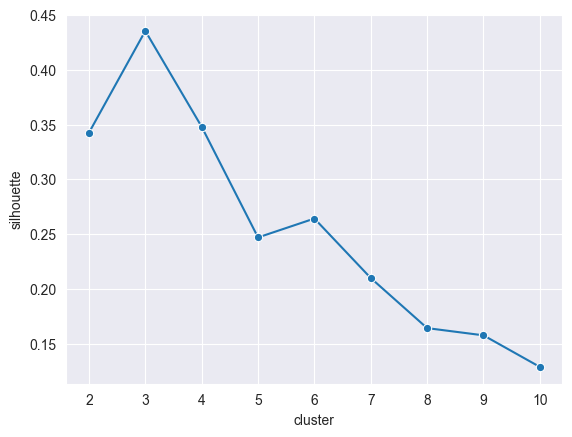

In [50]:
# напишем функцию силуэта
def get_silhouette(cluster_num, rfm_table_processed):
    k_means =  GaussianMixture(n_components=cluster_num, n_init=10, random_state=42)
    k_means.fit(rfm_table_processed)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(rfm_table_processed, k_means.predict(rfm_table_processed))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 11):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_table_processed))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")
print(f'Максимальное значение коэффициента силуэта:  {silhouette_df["silhouette"].max():.2f}')

#### Вывод: 
Как мы видим, лучшее количество кластеров = 3 

Максимальное значение коэффициента силуэта:  0.44

### Задание 5.6
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture


2) Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



В данном случае лучшей моделью оказалась KMeans

In [51]:
df_after_cluster = rfm_table_processed.copy()

In [52]:
model = KMeans(
    n_clusters=3,
    random_state=42
)

model.fit(rfm_table_processed)

#Получаем метки кластеров
cluster_labels = model.labels_

# Считаем количество клиентов в каждом кластере 
clients_count = pd.DataFrame(cluster_labels).value_counts()
# выводим максимальное количество клиентов для кластера
print(f'клиентов попало в самый большой кластер:{clients_count.max()}')

клиентов попало в самый большой кластер:2269


Визуализируем результаты кластеризации:

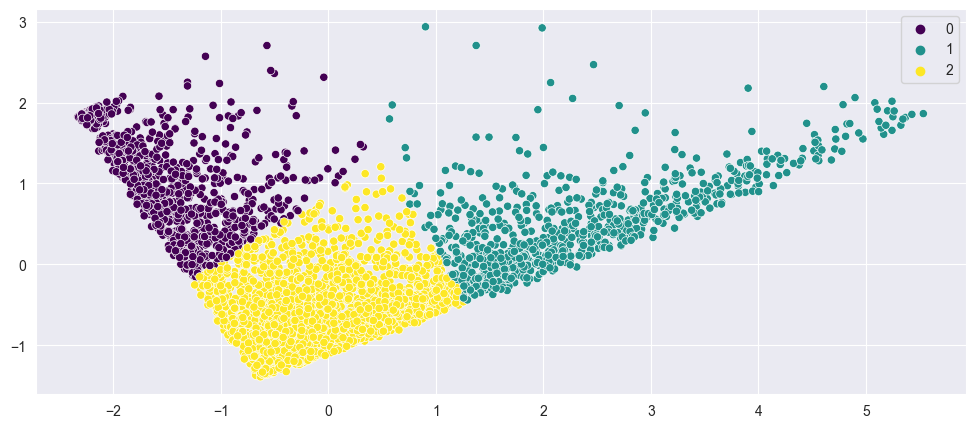

In [53]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x=rfm_table_processed[:,0],
    y=rfm_table_processed[:,1],
    hue=cluster_labels,
    palette='viridis'
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлим до целого числа.

In [54]:
# Создаем DataFrame с метками кластеров и RFM-таблицей
clustered_rfm = pd.concat([rfm_table_cleaned, pd.DataFrame(cluster_labels, columns=['Cluster'], index=rfm_table_cleaned.index)], axis=1)

# Группируем данные по меткам кластеров и рассчитываем среднее
cluster_profiles = clustered_rfm.groupby('Cluster').mean()

# Выводим профили кластеров
print(cluster_profiles)
# Выводим максимально среднее значение для Frequency
print(f'максимальное среднее значение признака Frequency:{cluster_profiles.max().round()}')

            Recency  Frequency  Monetary_value
Cluster                                       
0        253.474474   1.403403      386.277297
1         31.943299   7.068299     2657.746997
2         51.221684   2.329220      660.068947
максимальное среднее значение признака Frequency:Recency            253.0
Frequency            7.0
Monetary_value    2658.0
dtype: float64


### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [55]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаём список признаков
    features = grouped_data.columns
    # Создаём пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаём полярную диаграмму и добавляем её на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название — номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устанавливаем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    
    
    
    


Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируем кластеры и на основе анализа сопоставим номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


In [56]:
# используем функции
plot_cluster_profile(cluster_profiles, n_clusters=3)

#### Вывод: 
Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

Кластер 2 соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».

Кластер 0 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.



### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создаём pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучим ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и применим к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлим до двух знаков после точки-разделителя.

**Примечание:**
Дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



Первая главная компонента объясняет следующую долю дисперсии: 0.68


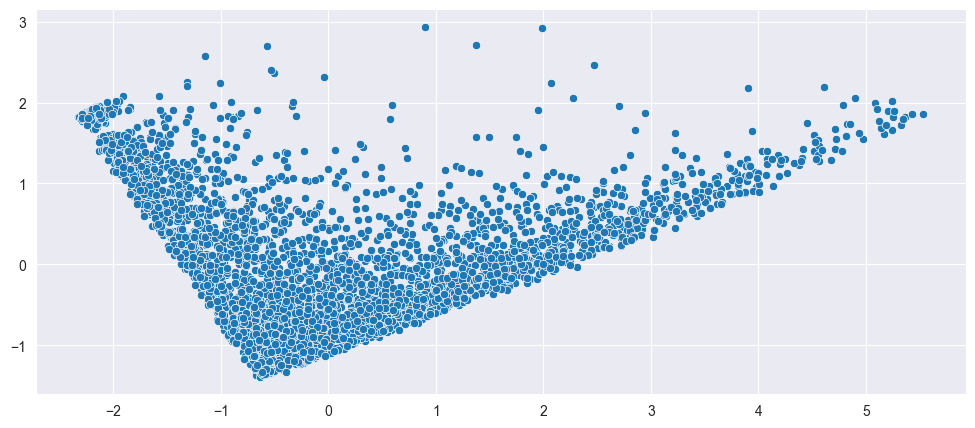

In [57]:
# Создаём pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('PCA', PCA(n_components = 2))
    
])
# обучаем и преобразовываем наш pipeline на RFM-таблице
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)
# Получаем объект PCA из pipeline
pca_component_first = pipeline['PCA'].explained_variance_ratio_[0]
# Выводим долю дисперсии первой главной компоненты 
print('Первая главная компонента объясняет следующую долю дисперсии:', round(pca_component_first, 2))

fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x=rfm_table_processed[:,0], y=rfm_table_processed[:,1]);

In [58]:
# Создаём pipeline
pipeline = Pipeline([
    ('Scaler', StandardScaler()),
    ('TSNE', TSNE(perplexity=50, random_state=100))

])

# обучаем и преобразовываем наш pipeline на RFM-таблице
rfm_table_processed = pipeline.fit_transform(rfm_table_cleaned)
# Получаем объект TSNE из pipeline и находим дивергенцию 
tsne_divergence = pipeline['TSNE'].kl_divergence_
# выводим дивергенцию 
print(f'Дивергенция Кульбака — Лейблера для обученного алгоритма t-SNE:{round(tsne_divergence,2)}')

Дивергенция Кульбака — Лейблера для обученного алгоритма t-SNE:0.54


Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


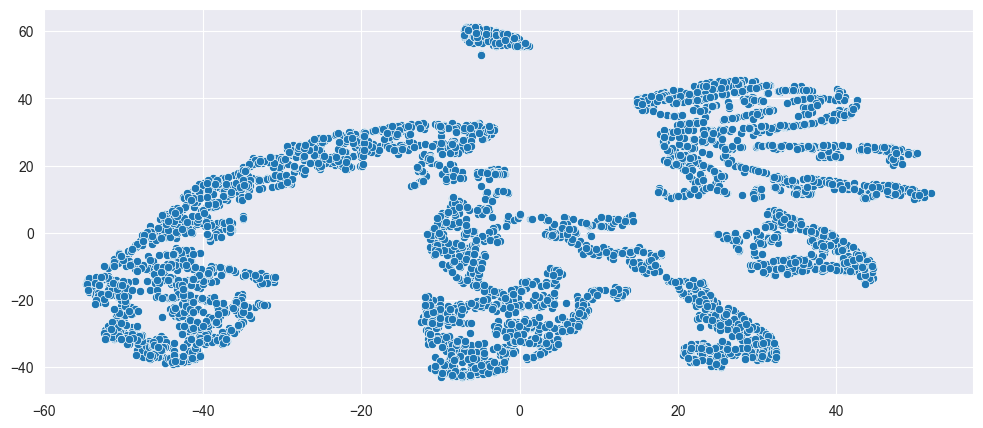

In [59]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x=rfm_table_processed[:,0], y=rfm_table_processed[:,1]);

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберём оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмём число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлим до двух знаков после точки-разделителя.



<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

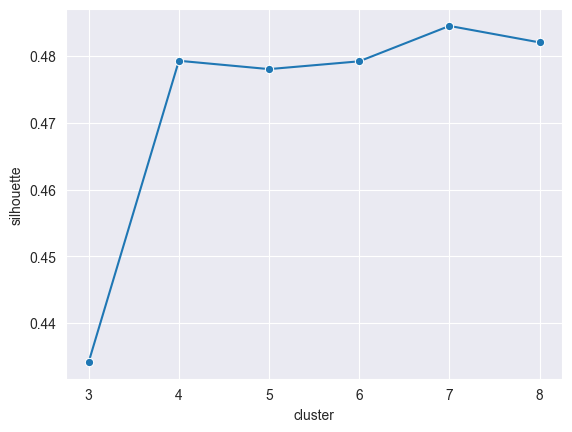

In [60]:
# напишем функцию коэффициента силуэта 
def get_silhouette(cluster_num, rfm_table_processed):
    k_means =  KMeans(n_clusters=cluster_num, init='k-means++', n_init=10, random_state=42)
    k_means.fit(rfm_table_processed)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(rfm_table_processed, k_means.predict(rfm_table_processed))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(3, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_table_processed))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [61]:

best_silhouette_agg = -1  # Начальное значение для отслеживания лучшего значения силуэта
best_n_clusters_agg = 0  # Здесь будем хранить лучшее количество кластеров

# Итерации по количеству кластеров
for n_clusters_agg in range(3, 9):
    # Выполняем KMeans кластеризацию
    agg_clustering = KMeans(n_clusters=n_clusters_agg)
    labels_agg = agg_clustering.fit_predict(rfm_table_processed)

    # Получаем коэффициент силуэта для текущего числа кластеров
    silhouette_agg = silhouette_score(rfm_table_processed, labels_agg)

    # Проверяем, является ли текущее значение силуэта лучшим
    if silhouette_agg > best_silhouette_agg:
        best_silhouette_agg = silhouette_agg
        best_n_clusters_agg = n_clusters_agg

print(f"Лучшее количество кластеров: {best_n_clusters_agg}")
print(f"Максимальное значение коэффициента силуэта: {best_silhouette_agg:.3f}")

Лучшее количество кластеров: 7
Максимальное значение коэффициента силуэта: 0.495


### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

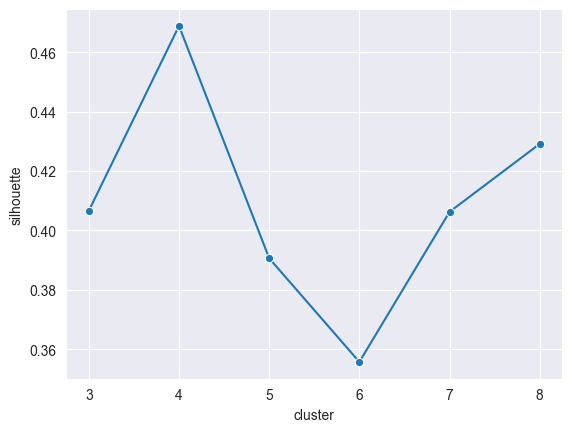

In [62]:
# напишем функцию коэффициента силуэта 
def get_silhouette(cluster_num, rfm_table_processed):
    gaus =  GaussianMixture(n_components=cluster_num, n_init=10, random_state=42)
    gaus.fit(rfm_table_processed)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(rfm_table_processed, gaus.predict(rfm_table_processed))
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(3, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_table_processed))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [63]:
best_silhouette_agg = -1  # Начальное значение для отслеживания лучшего значения силуэта
best_n_clusters_agg = 0  # Здесь будем хранить лучшее количество кластеров

# Итерации по количеству кластеров
for n_clusters_agg in range(3, 9):
    # Выполняем KMeans кластеризацию
    agg_clustering = GaussianMixture(n_components=n_clusters_agg, random_state=42)
    labels_agg = agg_clustering.fit_predict(rfm_table_processed)

    # Получаем коэффициент силуэта для текущего числа кластеров
    silhouette_agg = silhouette_score(rfm_table_processed, labels_agg)

    # Проверяем, является ли текущее значение силуэта лучшим
    if silhouette_agg > best_silhouette_agg:
        best_silhouette_agg = silhouette_agg
        best_n_clusters_agg = n_clusters_agg

print(f"Лучшее количество кластеров: {best_n_clusters_agg}")
print(f"Максимальное значение коэффициента силуэта: {best_silhouette_agg:.3f}")

Лучшее количество кластеров: 4
Максимальное значение коэффициента силуэта: 0.469


### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберём оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлим до двух знаков после точки-разделителя.



<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

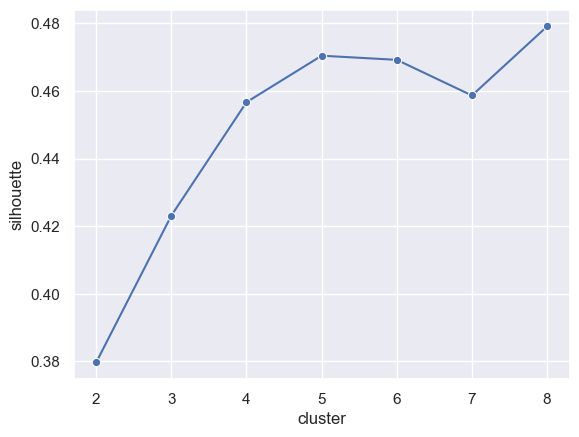

In [64]:
# напишем функцию коэффициента силуэта 
def get_silhouette(cluster_num, rfm_table_processed):
    agg_clustering =  AgglomerativeClustering(n_clusters=cluster_num)
    labels = agg_clustering.fit_predict(rfm_table_processed)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(rfm_table_processed, labels)
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 9):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, rfm_table_processed))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set(style='darkgrid')
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [65]:
best_silhouette_agg = -1  # Начальное значение для отслеживания лучшего значения силуэта
best_n_clusters_agg = 0  # Здесь будем хранить лучшее количество кластеров

# Итерации по количеству кластеров
for n_clusters_agg in range(2, 9):
    # Выполняем Агломеративную кластеризацию
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters_agg)
    labels_agg = agg_clustering.fit_predict(rfm_table_processed)

    # Получаем коэффициент силуэта для текущего числа кластеров
    silhouette_agg = silhouette_score(rfm_table_processed, labels_agg)

    # Проверяем, является ли текущее значение силуэта лучшим
    if silhouette_agg > best_silhouette_agg:
        best_silhouette_agg = silhouette_agg
        best_n_clusters_agg = n_clusters_agg

print(f"Лучшее количество кластеров: {best_n_clusters_agg}")
print(f"Максимальное значение коэффициента силуэта: {best_silhouette_agg:.3f}")

Лучшее количество кластеров: 8
Максимальное значение коэффициента силуэта: 0.479


In [66]:
rfm_table_copy = rfm_table_processed.copy()

### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



In [67]:
model = KMeans(
    n_clusters=7,
    random_state=42,
    n_init=10
)
# Обучаем модель
model.fit(rfm_table_processed)
# Получаем метки кластеров для каждого клиента
kmeans_labels = model.labels_
# Создаем DataFrame с метками кластеров
cluster_counts = pd.DataFrame({'Cluster': kmeans_labels})

# Выводим количество клиентов в каждом кластере
cluster_counts.value_counts()

Cluster
1          914
4          683
0          656
2          543
5          446
6          405
3          397
dtype: int64

### Вывод: 
Сколько клиентов попало в самый большой кластер - 914

Визуализируем результаты кластеризации:

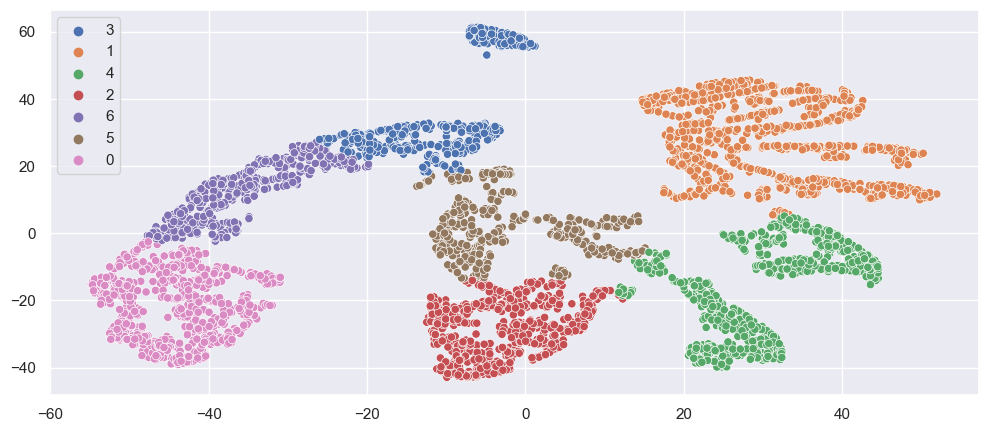

In [68]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x=rfm_table_processed[:,0], y=rfm_table_processed[:,1], hue=model.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

In [69]:
# Объединяем очищенные данные с метками кластеров
rfm_table_mean = rfm_table_cleaned.groupby(kmeans_labels).mean()
# выводим максимальное среднее значение для каждой группы
print(rfm_table_mean.round().max())

Recency            313.0
Frequency            7.0
Monetary_value    2417.0
dtype: float64


### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



In [70]:
# Используем функцию и создаём полярную диаграмму на основе средних RFM-характеристик 
plot_cluster_profile(rfm_table_mean, n_clusters=7)

#### Вывод: 

Кластер 1 соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.

Кластер 4 соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.

Кластер 2 соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».



Кластер 5 соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.



Кластер 0 соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму.


Кластер 6 соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более пяти месяцев назад и больше не возвращались.


Кластер 3 соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.

## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмём число 42.

Сколько клиентов попали в тестовую выборку?

In [71]:
# Создаём матрицу наблюдений X и вектор правильных ответов y
X = rfm_table_cleaned #очищенная RFM-таблица
y = kmeans_labels #метки кластеров, предсказанные ранее

In [72]:
# Разделяем данные на тренировочную и тестовыю выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Узнаём сколько клиентов у нас оказалось в тесте
print('Количество клиентов в тестовой выборке:', X_test.shape[0])

Количество клиентов в тестовой выборке: 809


Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучим GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделаем предсказание для тестовой выборки и рассчитаем метрику accuracy. Ответ округлим до трёх знаков после точки-разделителя.



In [73]:
# подбираем оптимальные параметры с помощью gridsearch
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
# Создаём модель случайного леса 
rf_model = RandomForestClassifier(random_state=42)

# Создаём  GridSearchCV
grid_search = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=-1)
# Обучаем на тренировочных данных 
grid_search.fit(X_train, y_train)
# Делаем предсказание для тестовой выборки
y_test_pred = grid_search.predict(X_test)
# Выводим метрики 
print(f"accuracy на тестовом наборе: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

accuracy на тестовом наборе: 0.985
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 13, 'n_estimators': 200}


Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

#### Вывод: 
Оптимальная максимальная глубина деревьев в случайном лесу - 13

### Задание 7.3
С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучим GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



In [74]:
# подбираем оптимальные параметры с помощью gridsearch
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
# Создаём модель Градиентного бустинга 
model = GradientBoostingClassifier(random_state=42)
# Создаём  GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
# Обучаем модель
grid_search.fit(X_train, y_train)
# Делаем предсказание для тестовой выборки 
y_test_pred = grid_search.predict(X_test)
# Выводим метрики 
print(f"accuracy на тестовом наборе: {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Наилучшие значения гиперпараметров: {grid_search.best_params_}")

accuracy на тестовом наборе: 0.983
Наилучшие значения гиперпараметров: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


#### Вывод: 
Оптимальная максимальная глубина деревьев в градиентном бустинге - 4 

Accuracy на тестовом наборе: 0.983

In [75]:
# Выведем все метрики 
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       140
           1       0.98      0.98      0.98       183
           2       0.99      0.99      0.99       109
           3       0.99      1.00      0.99        71
           4       0.98      0.96      0.97       133
           5       0.95      0.97      0.96        94
           6       0.99      0.97      0.98        79

    accuracy                           0.98       809
   macro avg       0.98      0.98      0.98       809
weighted avg       0.98      0.98      0.98       809



In [76]:
rfm_table_cleaned

,Recency,Frequency,Monetary_value
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40
...,...,...,...
18278,73,1,173.90
18280,277,1,180.60
18281,180,1,80.82


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.

### Выделим оптовиков в отдельный сегмент 

In [77]:
# Создание признака 'AvgQuantityPerOrder'
df['AvgQuantityPerOrder'] = df.groupby('CustomerID')['Quantity'].transform('mean')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391150 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   InvoiceNo            391150 non-null  object        
 1   StockCode            391150 non-null  object        
 2   Description          391150 non-null  object        
 3   Quantity             391150 non-null  int64         
 4   InvoiceDate          391150 non-null  datetime64[ns]
 5   UnitPrice            391150 non-null  float64       
 6   CustomerID           391150 non-null  object        
 7   Country              391150 non-null  object        
 8   QuantityCanceled     391150 non-null  float64       
 9   TotalPrice           391150 non-null  float64       
 10  Month                391150 non-null  int64         
 11  Week                 391150 non-null  object        
 12  Hour                 391150 non-null  int64         
 13  AvgQuantityPer

### Проведём стандартизацию текстовых данных, и векторизацию,  а также понижение размерности с помощью метода TruncatedSVD

In [78]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
# Выбор текстовых данных и их векторизация
product_descriptions = df['Description']

# Векторизация описаний товаров
vectorizer = TfidfVectorizer()
product_vectors = vectorizer.fit_transform(product_descriptions)

# Уменьшение размерности с использованием TruncatedSVD
svd = TruncatedSVD(n_components=20, random_state=42)
product_vectors_svd = svd.fit_transform(product_vectors)

# Стандартизация данных после применения TruncatedSVD
scaler = StandardScaler()
product_vectors_svd_scaled = scaler.fit_transform(product_vectors_svd)

### Определим оптимальное количество кластеров с помощью метода локтя 

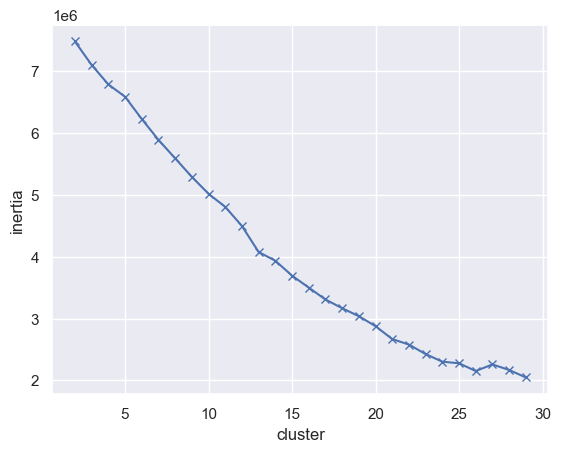

In [79]:

from sklearn.cluster import MiniBatchKMeans
# функция, которая принимает количество кластеров  и матрицу с признаками объектов и возвращает инерцию 
def get_inertia(cluster_num, product_vectors_svd_scaled):
# инициализируем алгоритм кластеризации
    minibatch =  MiniBatchKMeans(n_clusters=cluster_num, random_state=42, max_iter=100)
# запускаем алгоритм minibatch
    minibatch.fit(product_vectors_svd_scaled)
# находим значение инерции
    inertia = minibatch.inertia_
# возвращаем значение инерции
    return inertia

# создаём пустой список для значений инерции
inertia = []
# итерируемся по разным размерам кластеров (от 2 до 11) и сохраняем значение инерции для каждого кластера
for cluster_num in range(2, 30):
# сохраняем значения
    inertia.append(get_inertia(cluster_num, product_vectors_svd_scaled))

# визуализируем, как менялась инерция в зависимости от количества кластеров
# задаём названия осям x и y
plt.xlabel("cluster", fontsize=12)
plt.ylabel("inertia", fontsize=12)
# рисуем изменение инерции
plt.plot([i for i in range(2, 30)], inertia, 'xb-') 

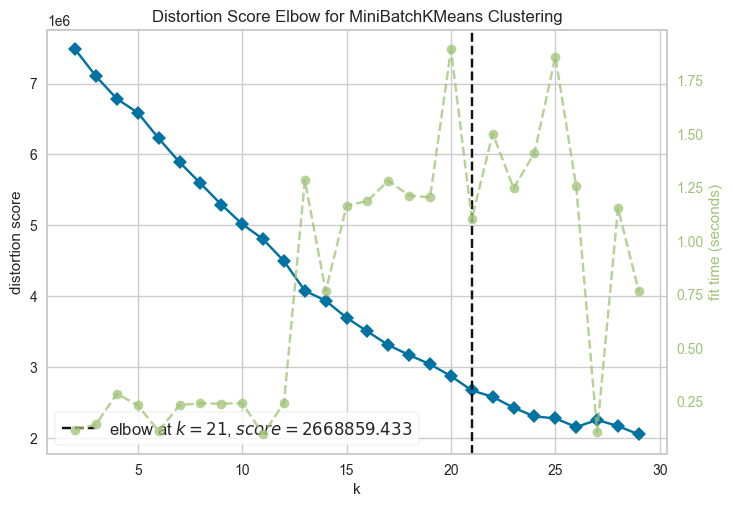

<AxesSubplot: title={'center': 'Distortion Score Elbow for MiniBatchKMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [80]:
from yellowbrick.cluster import KElbowVisualizer

# функция, которая принимает количество кластеров  и матрицу с признаками объектов и возвращает инерцию 
def get_inertia(cluster_num, product_vectors_svd_scaled):
    # инициализируем алгоритм кластеризации
    minibatch =  MiniBatchKMeans(n_clusters=cluster_num, random_state=42, max_iter=100)
    # запускаем алгоритм minibatch
    minibatch.fit(product_vectors_svd_scaled)
    # находим значение инерции
    inertia = minibatch.inertia_
    # возвращаем значение инерции
    return inertia

# создаём объект KElbowVisualizer
visualizer = KElbowVisualizer(MiniBatchKMeans(random_state=42, max_iter=100), k=(2,30))

# подготавливаем данные
visualizer.fit(product_vectors_svd_scaled)

# визуализируем локоть
visualizer.show()

#### Вывод: Мы видим что оптимальное количество кластеров у нас k = 21

### Кластерный анализ товаров на основе их описания 

In [81]:
# Кластерный анализ товаров
kmeans = MiniBatchKMeans(n_clusters=21, random_state=42)
product_clusters = kmeans.fit_predict(product_vectors_svd_scaled)

# Датасет с добавленными кластерами для товаров
df_products = pd.DataFrame({'Product': product_descriptions, 'Cluster': product_clusters})
print(df_products)

                                    Product  Cluster
0        WHITE HANGING HEART T-LIGHT HOLDER        4
1                       WHITE METAL LANTERN       12
2            CREAM CUPID HEARTS COAT HANGER        0
3       KNITTED UNION FLAG HOT WATER BOTTLE        2
4            RED WOOLLY HOTTIE WHITE HEART.       14
...                                     ...      ...
541904          PACK OF 20 SPACEBOY NAPKINS       16
541905         CHILDREN'S APRON DOLLY GIRL        19
541906        CHILDRENS CUTLERY DOLLY GIRL        19
541907      CHILDRENS CUTLERY CIRCUS PARADE        0
541908        BAKING SET 9 PIECE RETROSPOT        13

[391150 rows x 2 columns]


### Расчет частоты покупки категорий товаров для каждого клиента

In [82]:

df_purchases = pd.DataFrame({'CustomerID': df['CustomerID'], 'Product': product_descriptions, 'Quantity': df['Quantity']})

# Объединение данных по товарам и клиентам
df_merged = pd.merge(df_purchases, df_products, on='Product', how='left')

# Рассчет частоты покупок для каждого кластера и клиента
df_cluster_freq = df_merged.groupby(['CustomerID', 'Cluster'])['Quantity'].sum().reset_index()

# Подсчет общей суммы покупок для каждого клиента
df_total_freq = df_merged.groupby('CustomerID')['Quantity'].sum().reset_index()

# Объединение результатов
df_final = pd.merge(df_cluster_freq, df_total_freq, on='CustomerID', suffixes=('_cluster', '_total'))

# Рассчет частоты покупок каждого кластера относительно общей суммы покупок
df_final['Cluster_Frequency'] = df_final['Quantity_cluster'] / df_final['Quantity_total']

# Вывод результирующего датафрейма
print(df_final)

#### Топ-10 характеристик описания товаров для каждого кластера.

In [ ]:
# Группировка данных по кластерам и описаниям товаров, суммирование частоты покупок
cluster_description_counts = df_merged.groupby(['Cluster', 'Product'])['Quantity'].sum().reset_index()

# Сортировка данных по убыванию частоты покупок в каждом кластере
cluster_description_sorted = cluster_description_counts.sort_values(by=['Cluster', 'Quantity'], ascending=False)

# Вывод топ-10 характеристик описания товаров для каждого кластера
for cluster_num in range(21):
    top_10_cluster_description = cluster_description_sorted[cluster_description_sorted['Cluster'] == cluster_num].head(10)
    
    display(f'Top 10 Characteristics for Cluster {cluster_num}:')
    display(top_10_cluster_description[['Product', 'Quantity']])
    

'Top 10 Characteristics for Cluster 0:'

,Product,Quantity
145,ASSORTED COLOUR BIRD ORNAMENT,49191885
2263,WORLD WAR 2 GLIDERS ASSTD DESIGNS,25638568
1331,MEDIUM CERAMIC TOP STORAGE JAR,15427368
1760,RED RETROSPOT CHARLOTTE BAG,9578140
1988,SMALL POPCORN HOLDER,7424087
151,ASSORTED COLOURS SILK FAN,7109700
1792,RED TOADSTOOL LED NIGHT LIGHT,6791664
63,6 RIBBONS RUSTIC CHARM,6368154
1124,HOMEMADE JAM SCENTED CANDLES,6257440
940,GARDENERS KNEELING PAD KEEP CALM,5884164


'Top 10 Characteristics for Cluster 1:'

,Product,Quantity
2329,ALARM CLOCK BAKELIKE RED,6384516
2325,ALARM CLOCK BAKELIKE GREEN,4487110
2328,ALARM CLOCK BAKELIKE PINK,3135854
2326,ALARM CLOCK BAKELIKE IVORY,1278870
2327,ALARM CLOCK BAKELIKE ORANGE,793156
2324,ALARM CLOCK BAKELIKE CHOCOLATE,575900
2337,RED DINER WALL CLOCK,561184
2332,IVORY DINER WALL CLOCK,559086
2331,BLUE DINER WALL CLOCK,306566
2335,MINT DINER WALL CLOCK,55902


'Top 10 Characteristics for Cluster 2:'

,Product,Quantity
2354,HOT WATER BOTTLE KEEP CALM,3883803
2346,CHOCOLATE HOT WATER BOTTLE,3637312
2362,SCOTTIE DOG HOT WATER BOTTLE,2807928
2356,HOT WATER BOTTLE TEA AND SYMPATHY,1924164
2361,RETROSPOT HEART HOT WATER BOTTLE,1799366
2349,GREY HEART HOT WATER BOTTLE,1669995
2353,HOT WATER BOTTLE I AM SO POORLY,1490073
2348,FAWN BLUE HOT WATER BOTTLE,1115058
2358,LOVE HOT WATER BOTTLE,1067175
2364,WHITE SKULL HOT WATER BOTTLE,1047212


'Top 10 Characteristics for Cluster 3:'

,Product,Quantity
2370,HOME BUILDING BLOCK WORD,1829935
2383,HOME SWEET HOME MUG,1569960
2365,DOORMAT FANCY FONT HOME SWEET HOME,1225539
2367,DOORMAT SPOTTY HOME SWEET HOME,671085
2368,DOORMAT WELCOME TO OUR HOME,465088
2382,HOME SWEET HOME METAL SIGN,424576
2366,DOORMAT HOME SWEET HOME BLUE,417890
2379,HOME SWEET HOME HANGING HEART,335775
2385,MAGNETS PACK OF 4 HOME SWEET HOME,200970
2378,HOME SWEET HOME CUSHION COVER,154889


'Top 10 Characteristics for Cluster 4:'

,Product,Quantity
2463,WHITE HANGING HEART T-LIGHT HOLDER,73999296
2440,RABBIT NIGHT LIGHT,22346919
2439,POPCORN HOLDER,20190107
2460,VICTORIAN GLASS HANGING T-LIGHT,18348876
2400,COLOUR GLASS T-LIGHT HOLDER HANGING,8248390
2393,ANTIQUE SILVER T-LIGHT GLASS,6953613
2417,HANGING HEART JAR T-LIGHT HOLDER,6324497
2441,RED HANGING HEART T-LIGHT HOLDER,5339061
2418,HANGING HEART ZINC T-LIGHT HOLDER,3478928
2419,HANGING JAM JAR T-LIGHT HOLDER,3274208


'Top 10 Characteristics for Cluster 5:'

,Product,Quantity
2632,VINTAGE SNAP CARDS,9743499
2515,MINI PAINT SET VINTAGE,8474700
2513,JUMBO SHOPPER VINTAGE RED PAISLEY,8318570
2600,VINTAGE HEADS AND TAILS CARD GAME,3480702
2535,PLASTERS IN TIN VINTAGE PAISLEY,2231796
2498,CHARLOTTE BAG VINTAGE ALPHABET,1543750
2560,TRAVEL CARD WALLET VINTAGE TICKET,1352920
2592,VINTAGE DOILY TRAVEL SEWING KIT,1258728
2490,BOX OF 6 MINI VINTAGE CRACKERS,1221075
2550,SET OF 6 RIBBONS VINTAGE CHRISTMAS,962421


'Top 10 Characteristics for Cluster 6:'

,Product,Quantity
2668,PACK OF 72 RETROSPOT CAKE CASES,35353500
2666,PACK OF 60 PINK PAISLEY CAKE CASES,16379480
2657,60 TEATIME FAIRY CAKE CASES,11870208
2669,PACK OF 72 SKULL CAKE CASES,7222510
2655,60 CAKE CASES VINTAGE CHRISTMAS,7047048
2659,72 SWEETHEART FAIRY CAKE CASES,6709935
2664,PACK OF 60 DINOSAUR CAKE CASES,6573558
2672,SET OF 60 PANTRY DESIGN CAKE CASES,6017076
2670,SET OF 12 FAIRY CAKE BAKING CASES,3842476
2667,PACK OF 60 SPACEBOY CAKE CASES,3352158


'Top 10 Characteristics for Cluster 7:'

,Product,Quantity
2751,PAPER CHAIN KIT 50'S CHRISTMAS,15637773
2756,PAPER CHAIN KIT VINTAGE CHRISTMAS,6652638
2747,JUMBO BAG 50'S CHRISTMAS,5288336
2783,WOODEN HEART CHRISTMAS SCANDINAVIAN,4685578
2784,WOODEN STAR CHRISTMAS SCANDINAVIAN,4342228
2728,DISCO BALL CHRISTMAS DECORATION,2321712
2754,PAPER CHAIN KIT RETROSPOT,1897925
2752,PAPER CHAIN KIT EMPIRE,1856300
2694,CHRISTMAS CRAFT LITTLE FRIENDS,1487370
2785,WOODEN TREE CHRISTMAS SCANDINAVIAN,1379035


'Top 10 Characteristics for Cluster 8:'

,Product,Quantity
2869,RED HARMONICA IN BOX,11812980
2900,SPACEBOY LUNCH BOX,9860772
2866,RECIPE BOX PANTRY YELLOW DESIGN,6157976
2835,LUNCH BOX I LOVE LONDON,5747925
2901,STRAWBERRY CERAMIC TRINKET BOX,4761498
2854,PINK BLUE FELT CRAFT TRINKET BOX,4710037
2862,PLASTERS IN TIN SPACEBOY,4486416
2864,PLASTERS IN TIN WOODLAND ANIMALS,4341715
2794,BLUE HARMONICA IN BOX,3893844
2855,PINK CREAM FELT CRAFT TRINKET BOX,3844346


'Top 10 Characteristics for Cluster 9:'

,Product,Quantity
2928,PARTY BUNTING,21222531
2932,SPOTTY BUNTING,7739862
2924,PAPER BUNTING RETROSPOT,3926767
2934,TEA PARTY BIRTHDAY CARD,1089083
2937,VINTAGE UNION JACK BUNTING,1015200
2936,VINTAGE CHRISTMAS BUNTING,1005768
2927,PAPER BUNTING WHITE LACE,988264
2930,PINK HAPPY BIRTHDAY BUNTING,821880
2935,TEA TIME PARTY BUNTING,718432
2920,BLUE HAPPY BIRTHDAY BUNTING,691540


'Top 10 Characteristics for Cluster 10:'

,Product,Quantity
2947,LUNCH BAG RED RETROSPOT,22901528
2941,LUNCH BAG BLACK SKULL.,12123188
2944,LUNCH BAG CARS BLUE,10540853
2943,LUNCH BAG APPLE DESIGN,10123340
2950,LUNCH BAG SPACEBOY DESIGN,9805875
2952,LUNCH BAG SUKI DESIGN,8756550
2956,LUNCH BAG WOODLAND,7554621
2940,CHARLOTTE BAG SUKI DESIGN,5278730
2942,LUNCH BAG ALPHABET DESIGN,4971780
2955,LUNCH BAG VINTAGE LEAF DESIGN,3739364


'Top 10 Characteristics for Cluster 11:'

,Product,Quantity
2966,JUMBO BAG RED RETROSPOT,74415970
2970,JUMBO BAG STRAWBERRY,11001776
2959,JUMBO BAG APPLES,10045500
2958,JUMBO BAG ALPHABET,9487481
2978,JUMBO STORAGE BAG SUKI,8980140
2957,JUMBO BAG BAROQUE BLACK WHITE,8377776
2975,JUMBO BAG VINTAGE LEAF,8331405
2974,JUMBO BAG VINTAGE DOILY,6669360
2965,JUMBO BAG PINK VINTAGE PAISLEY,5982240
2984,WOODLAND CHARLOTTE BAG,4959822


'Top 10 Characteristics for Cluster 12:'

,Product,Quantity
3076,WOODEN PICTURE FRAME WHITE FINISH,7281792
3075,WOODEN FRAME ANTIQUE WHITE,5114688
2994,BLACK RECORD COVER FRAME,3579914
3073,WOOD BLACK BOARD ANT WHITE FINISH,3571452
3009,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,1849839
3001,BLUE STRIPE CERAMIC DRAWER KNOB,1772024
3041,RED STRIPE CERAMIC DRAWER KNOB,1680336
3034,PHOTO FRAME CORNICE,1451432
3060,WHITE SPOT RED CERAMIC DRAWER KNOB,1410074
3072,WOOD 2 DRAWER CABINET WHITE FINISH,1189888


'Top 10 Characteristics for Cluster 13:'

,Product,Quantity
3115,JAM MAKING SET PRINTED,13083930
3246,SET OF 4 PANTRY JELLY MOULDS,10368489
3292,SET/20 RED RETROSPOT PAPER NAPKINS,9179530
3200,SET OF 3 CAKE TINS PANTRY DESIGN,8075520
3116,JAM MAKING SET WITH JARS,7155060
3138,ROUND SNACK BOXES SET OF4 WOODLAND,4812700
3311,SET/5 RED RETROSPOT LID GLASS BOWLS,4538283
3085,BAKING SET 9 PIECE RETROSPOT,4106388
3195,SET OF 20 VINTAGE CHRISTMAS NAPKINS,4071722
3271,SET OF 6 SPICE TINS PANTRY DESIGN,3553680


'Top 10 Characteristics for Cluster 14:'

,Product,Quantity
3460,NATURAL SLATE HEART CHALKBOARD,8191044
3478,PLACE SETTING WHITE HEART,4396488
3380,CREAM HEART CARD HOLDER,3717352
3522,ZINC METAL HEART DECORATION,2794500
3400,GINGHAM HEART DECORATION,2011438
3406,HAND WARMER RED LOVE HEART,1436306
3419,HEART FILIGREE DOVE SMALL,1361948
3494,SMALL GLASS HEART TRINKET POT,1256752
3484,RED WOOLLY HOTTIE WHITE HEART.,1187348
3438,JINGLE BELL HEART DECORATION,1169922


'Top 10 Characteristics for Cluster 15:'

,Product,Quantity
3581,PLEASE ONE PERSON METAL SIGN,8412060
3549,GIN + TONIC DIET METAL SIGN,7567658
3530,COOK WITH WINE METAL SIGN,6172583
3552,HAND OVER THE CHOCOLATE SIGN,4817696
3556,HOT BATHS METAL SIGN,2495864
3526,BATHROOM METAL SIGN,2124158
3576,NO SINGING METAL SIGN,1793745
3524,AREA PATROLLED METAL SIGN,1612288
3579,PAINTED METAL PEARS ASSORTED,1594532
3587,YOU'RE CONFUSING ME METAL SIGN,1485960


'Top 10 Characteristics for Cluster 16:'

,Product,Quantity
3611,PACK OF 12 LONDON TISSUES,9928968
3626,PACK OF 20 NAPKINS PANTRY DESIGN,3372752
3610,PACK OF 12 HEARTS DESIGN TISSUES,3040596
3621,PACK OF 12 TRADITIONAL CRAYONS,2989473
3590,12 PENCILS SMALL TUBE SKULL,2011373
3630,PACK OF 6 BIRDY GIFT TAGS,2002881
3589,12 PENCILS SMALL TUBE RED RETROSPOT,1988223
3620,PACK OF 12 SUKI TISSUES,1837262
3616,PACK OF 12 RED RETROSPOT TISSUES,1630250
3627,PACK OF 20 NAPKINS RED APPLES,1353280


'Top 10 Characteristics for Cluster 17:'

,Product,Quantity
3646,HEART OF WICKER SMALL,16415872
3645,HEART OF WICKER LARGE,7766947
3650,SMALL WHITE HEART OF WICKER,2540152
3649,LARGE WHITE HEART OF WICKER,1495164
3647,IVORY WICKER HEART LARGE,546204
3643,DECORATIVE WICKER HEART LARGE,394632
3648,IVORY WICKER HEART SMALL,217554
3644,DECORATIVE WICKER HEART SMALL,128312


'Top 10 Characteristics for Cluster 18:'

,Product,Quantity
3660,REGENCY CAKESTAND 3 TIER,21196662
3670,ROSES REGENCY TEACUP AND SAUCER,7213129
3656,GREEN REGENCY TEACUP AND SAUCER,4484200
3671,SET OF 3 REGENCY CAKE TINS,4213524
3657,PINK REGENCY TEACUP AND SAUCER,2966613
3666,REGENCY TEA PLATE ROSES,2152664
3664,REGENCY TEA PLATE GREEN,1616786
3669,REGENCY TEAPOT ROSES,950334
3661,REGENCY MILK JUG PINK,832864
3665,REGENCY TEA PLATE PINK,826112


'Top 10 Characteristics for Cluster 19:'

,Product,Quantity
3687,DOLLY GIRL LUNCH BOX,7054229
3693,LUNCH BAG DOLLY GIRL DESIGN,3955362
3676,60 CAKE CASES DOLLY GIRL DESIGN,2588749
3678,CHARLOTTE BAG DOLLY GIRL DESIGN,1757555
3691,JUMBO BAG DOLLY GIRL DESIGN,981432
3677,CARD DOLLY GIRL,909723
3694,MAGIC DRAWING SLATE DOLLY GIRL,642513
3679,CHILDREN'S APRON DOLLY GIRL,517041
3680,CHILDRENS CUTLERY DOLLY GIRL,437670
3697,SET 12 COLOUR PENCILS DOLLY GIRL,391664


'Top 10 Characteristics for Cluster 20:'

,Product,Quantity
3762,JUMBO BAG PINK POLKADOT,17810832
3766,LUNCH BAG PINK POLKADOT,9622666
3726,CHARLOTTE BAG PINK POLKADOT,3607682
3853,SET/10 RED POLKADOT PARTY CANDLES,2209320
3852,SET/10 PINK POLKADOT PARTY CANDLES,1627810
3724,BLUE POLKADOT WRAP,1483500
3829,PINK POLKADOT WRAP,1352550
3800,PINK FAIRY CAKE CHILDRENS APRON,1246580
3729,CHILDRENS CUTLERY POLKADOT PINK,1150128
3859,SMALL MARSHMALLOWS PINK BOWL,975645


#### Вывод 

Топ-продукты: Некоторые товары, такие как "WHITE HANGING HEART T-LIGHT HOLDER" и "JUMBO BAG RED RETROSPOT", явно выделяются по количеству продаж. Эти товары могут быть ключевыми продуктами или особенно популярными у клиентов.

Кластеры показывают разнообразие товаров, и большинство из них имеют уникальные идентификаторы или характеристики. Некоторые кластеры могут представлять собой определенные категории товаров или стили, например, "CHRISTMAS" или "VINTAGE". Некоторые кластеры и продукты могут быть связаны с определенными событиями или сезонами. Например, кластеры, связанные с Рождеством или декором дома, могут быть популярными в определенные периоды года.


#### Идеи
#### Стратегии маркетинга: 

Результаты анализа предоставляют возможность разработки персонализированных стратегий маркетинга. Например, можно предложить клиентам товары из наиболее популярных кластеров с целью увеличения продаж и удовлетворения их предпочтений.

Учитывая некоторые товары, связанные с определенными сезонами или праздниками, можно разработать сезонные акции или специальные предложения.

Основываясь на анализе популярных товаров, можно рассмотреть возможность расширения ассортимента в определенных категориях или стилях, которые пользуются большим спросом.

Учитывая популярность определенных товаров, оптимизировать свои запасы, чтобы удовлетворять спрос и избегать избыточного запаса.

Использовать дополнительные данные для анализа поведения покупателей. Можно  понять, почему определенные товары пользуются большим спросом.